### 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from geopy.geocoders import Nominatim
import folium

c:\Users\Umair Sayed\anaconda3\envs\ds_proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Read and Explore the Data

#### 1.1 Load Training Data (Synthetic Data)

In [2]:
df_train = pd.read_excel('./data/synthetic_training_improved.xlsx')
df_train.head()

,sentence,city,is_journey
0,"His journal contained the following entries: ""...",Liverpool,0
1,Regular service connects Aden with Allahabad,Aden,0
2,His notebook listed the principal points: Chic...,Chicago,0
3,The Cairo and Calcutta Railroad provided relia...,Calcutta,0
4,"His journal contained the following entries: ""...",Paris,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    5045 non-null   object
 1   city        5045 non-null   object
 2   is_journey  5045 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 118.4+ KB


In [4]:
print(f"Training data shape: {df_train.shape}")
print(f"Total training examples: {df_train.shape[0]}")

Training data shape: (5045, 3)
Total training examples: 5045


In [5]:
print("\nLabel Distribution (Training):")
print(df_train['is_journey'].value_counts())
print(f"\nNot Visited (0): {len(df_train[df_train['is_journey']==0])}")
print(f"Visited (1): {len(df_train[df_train['is_journey']==1])}")


Label Distribution (Training):
is_journey
0    3159
1    1886
Name: count, dtype: int64

Not Visited (0): 3159
Visited (1): 1886


#### 1.2 Load Test Data (Actual Book Sentences)

In [6]:
df_test = pd.read_excel('./data/sentence_city_pairs.xlsx')
df_test.head()

,chapter,sent_num,sentence,cities,is_journey
0,1,5,"Certainly an Englishman, it was more doubtful ...",London,0
1,1,6,"He was never seen on ’Change, nor at the Bank,...",London,0
2,1,6,"He was never seen on ’Change, nor at the Bank,...",Temple,0
3,1,25,It was at least certain that Phileas Fogg had ...,London,0
4,1,51,"Then I got to be a professor of gymnastics, so...",Paris,0


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chapter     571 non-null    int64 
 1   sent_num    571 non-null    int64 
 2   sentence    571 non-null    object
 3   cities      571 non-null    object
 4   is_journey  571 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 22.4+ KB


In [8]:
print("\nLabel Distribution (Test):")
print(df_test['is_journey'].value_counts())
print(f"\nNot Visited (0): {len(df_test[df_test['is_journey']==0])}")
print(f"Visited (1): {len(df_test[df_test['is_journey']==1])}")
print(f"\nActual cities visited: {df_test[df_test['is_journey']==1]['cities'].nunique()}")


Label Distribution (Test):
is_journey
0    493
1     78
Name: count, dtype: int64

Not Visited (0): 493
Visited (1): 78

Actual cities visited: 28


### 2. Data Preparation and Preprocessing

#### 2.1 Prepare Training Data (Synthetic)

In [9]:
# Extract features (sentences and cities) and labels from training data
X_train = df_train[['sentence', 'city']]
y_train = df_train['is_journey']

print("Training Set Preparation:")
print("="*40)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Training Set Preparation:
X_train shape: (5045, 2)
y_train shape: (5045,)


#### 2.2 Prepare Test Data

In [ ]:
# Extract features (sentences and cities) and labels from test data
# Keep chapter and sent_num for chronological ordering
X_test = df_test[['sentence', 'cities', 'chapter', 'sent_num']]
X_test = X_test.rename(columns={'cities': 'city'})
y_test = df_test['is_journey']

print("Test Set Preparation:")
print("="*40)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Test Set Preparation:
X_test shape: (571, 4)
y_test shape: (571,)


### 3. Helper Functions

#### 3.1 Model Evaluation Function

In [ ]:
def evaluate_model(y_true, y_pred, model_name=None):
    """
    Calculate and display key performance metrics for binary classification.
    """

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Print metrics
    print("=" * 60)
    print(f"{model_name} - PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Accuracy:   {accuracy:.4f}  ({accuracy*100:.2f}%)")
    print(f"Precision:  {precision:.4f}  ({precision*100:.2f}%)")
    print(f"Recall:     {recall:.4f}  ({recall*100:.2f}%)")
    print(f"F1 Score:   {f1:.4f}  ({f1*100:.2f}%)")
    print("=" * 60)

    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=['Not Visited (0)', 'Visited (1)'],
        cmap='Blues'
    )
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Return metrics dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def compute_training_metrics(eval_pred):
    """Compute metrics during training"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

### 4. Model Training and Evaluation

#### 4.1 BERT Model

##### 4.1.1 Initialize BERT Model and Tokenizer

We use the pre-trained `bert-base-uncased` model from Hugging Face with a binary classification head (2 labels: visited/not visited). The model automatically utilizes GPU (CUDA) if available for faster training.

In [12]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
).to(device)

Using device: cuda


c:\Users\Umair Sayed\anaconda3\envs\ds_proj\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassif

##### 4.1.2 Prepare Data for BERT

We prepare the training and test data by combining sentence and city into a single input text, then tokenizing for BERT.

In [13]:
# Create input text format: sentence [SEP] city
def create_input_text(row):
    return f"{row['sentence']} [SEP] {row['city']}"

X_train['input_text'] = X_train.apply(create_input_text, axis=1)
X_test['input_text'] = X_test.apply(create_input_text, axis=1)

In [14]:
# Custom Dataset class for PyTorch
class JourneyDataset(Dataset):
    """Custom Dataset for Journey Classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [15]:
# Create training dataset
train_dataset = JourneyDataset(X_train['input_text'], y_train, tokenizer)
test_dataset = JourneyDataset(X_test['input_text'], y_test, tokenizer)

##### 4.1.3 Train BERT Model

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',              # Saves model checkpoints
    num_train_epochs=3,                  # Number of training epochs
    per_device_train_batch_size=16,      # Batch size for training
    warmup_steps=100,                    # Learning rate warmup
    weight_decay=0.01,                   # Regularization
    logging_steps=50,                    # Show progress every 50 steps
    save_strategy="epoch",               # Save model after each epoch
    save_total_limit=2,                  # Keep only last 2 checkpoints
    report_to="none"                     # Disable wandb
)

In [17]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_training_metrics
)

# Train the model
trainer.train()

c:\Users\Umair Sayed\anaconda3\envs\ds_proj\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5045
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 948
  Number of trainable parameters = 109483778
  5%|▌         | 50/948 [00:19<05:36,  2.67it/s]

{'loss': 0.6392, 'learning_rate': 2.5e-05, 'epoch': 0.16}


 11%|█         | 100/948 [00:38<05:15,  2.69it/s]

{'loss': 0.4581, 'learning_rate': 5e-05, 'epoch': 0.32}


 16%|█▌        | 150/948 [00:57<05:01,  2.65it/s]

{'loss': 0.3052, 'learning_rate': 4.705188679245283e-05, 'epoch': 0.47}


 21%|██        | 200/948 [01:15<04:06,  3.03it/s]

{'loss': 0.286, 'learning_rate': 4.410377358490566e-05, 'epoch': 0.63}


 26%|██▋       | 250/948 [01:31<03:27,  3.36it/s]

{'loss': 0.1607, 'learning_rate': 4.115566037735849e-05, 'epoch': 0.79}


 32%|███▏      | 300/948 [01:45<03:11,  3.38it/s]

{'loss': 0.0886, 'learning_rate': 3.820754716981133e-05, 'epoch': 0.95}


 33%|███▎      | 316/948 [01:50<02:48,  3.76it/s]Saving model checkpoint to ./results\checkpoint-316
Configuration saved in ./results\checkpoint-316\config.json
Model weights saved in ./results\checkpoint-316\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-632] due to args.save_total_limit
 37%|███▋      | 350/948 [02:05<02:59,  3.32it/s]

{'loss': 0.0345, 'learning_rate': 3.525943396226416e-05, 'epoch': 1.11}


 42%|████▏     | 400/948 [02:20<02:44,  3.33it/s]

{'loss': 0.051, 'learning_rate': 3.2311320754716986e-05, 'epoch': 1.27}


 47%|████▋     | 450/948 [02:35<02:28,  3.36it/s]

{'loss': 0.011, 'learning_rate': 2.9363207547169812e-05, 'epoch': 1.42}


 53%|█████▎    | 500/948 [02:51<02:16,  3.28it/s]

{'loss': 0.0116, 'learning_rate': 2.641509433962264e-05, 'epoch': 1.58}


 58%|█████▊    | 550/948 [03:06<02:02,  3.25it/s]

{'loss': 0.0408, 'learning_rate': 2.346698113207547e-05, 'epoch': 1.74}


 63%|██████▎   | 600/948 [03:22<01:47,  3.25it/s]

{'loss': 0.0073, 'learning_rate': 2.0518867924528304e-05, 'epoch': 1.9}


 67%|██████▋   | 632/948 [03:31<01:22,  3.83it/s]Saving model checkpoint to ./results\checkpoint-632
Configuration saved in ./results\checkpoint-632\config.json
Model weights saved in ./results\checkpoint-632\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-948] due to args.save_total_limit
 69%|██████▊   | 650/948 [03:41<01:29,  3.34it/s]

{'loss': 0.0108, 'learning_rate': 1.7570754716981134e-05, 'epoch': 2.06}


 74%|███████▍  | 700/948 [03:56<01:14,  3.31it/s]

{'loss': 0.0006, 'learning_rate': 1.4622641509433963e-05, 'epoch': 2.22}


 79%|███████▉  | 750/948 [04:11<01:00,  3.28it/s]

{'loss': 0.0169, 'learning_rate': 1.1674528301886793e-05, 'epoch': 2.37}


 84%|████████▍ | 800/948 [04:27<00:45,  3.27it/s]

{'loss': 0.0094, 'learning_rate': 8.726415094339622e-06, 'epoch': 2.53}


 90%|████████▉ | 850/948 [04:42<00:30,  3.26it/s]

{'loss': 0.0003, 'learning_rate': 5.778301886792453e-06, 'epoch': 2.69}


 95%|█████████▍| 900/948 [04:58<00:14,  3.20it/s]

{'loss': 0.0096, 'learning_rate': 2.830188679245283e-06, 'epoch': 2.85}


100%|██████████| 948/948 [05:12<00:00,  3.62it/s]Saving model checkpoint to ./results\checkpoint-948
Configuration saved in ./results\checkpoint-948\config.json
Model weights saved in ./results\checkpoint-948\pytorch_model.bin
Deleting older checkpoint [results\checkpoint-316] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 948/948 [05:16<00:00,  2.99it/s]

{'train_runtime': 316.9692, 'train_samples_per_second': 47.749, 'train_steps_per_second': 2.991, 'train_loss': 0.1129600187824481, 'epoch': 3.0}


TrainOutput(global_step=948, training_loss=0.1129600187824481, metrics={'train_runtime': 316.9692, 'train_samples_per_second': 47.749, 'train_steps_per_second': 2.991, 'train_loss': 0.1129600187824481, 'epoch': 3.0})

##### 4.1.4 Evaluate BERT on Test Data

***** Running Prediction *****
  Num examples = 571
  Batch size = 8
100%|██████████| 72/72 [00:03<00:00, 19.04it/s]


BERT - PERFORMANCE METRICS
Accuracy:   0.8949  (89.49%)
Precision:  0.5865  (58.65%)
Recall:     0.7821  (78.21%)
F1 Score:   0.6703  (67.03%)


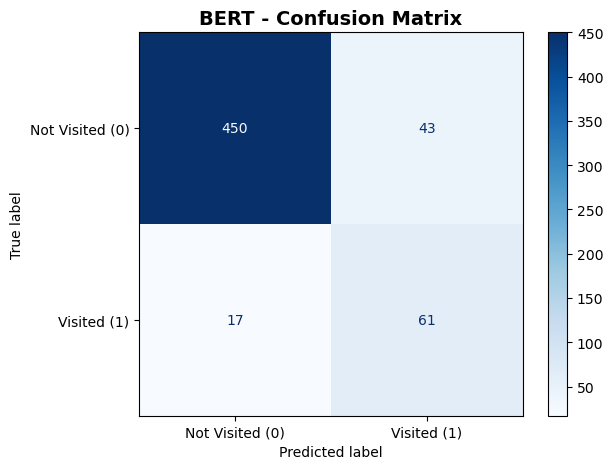

In [18]:
# Get predictions on test set
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)

# Evaluate and display metrics
bert_results = evaluate_model(y_test, y_pred_bert, model_name="BERT")

#### 4.2 RoBERTa Model

##### 4.2.1 Initialize RoBERTa Model and Tokenizer

We use the pre-trained `roberta-base` model with a binary classification head.

In [19]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load RoBERTa model and tokenizer
model_name_roberta = 'roberta-base'
tokenizer_roberta = RobertaTokenizer.from_pretrained(model_name_roberta)
model_roberta = RobertaForSequenceClassification.from_pretrained(
    model_name_roberta,
    num_labels=2,
    problem_type="single_label_classification"
).to(device)

c:\Users\Umair Sayed\anaconda3\envs\ds_proj\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading file vocab.json from cache at C:\Users\Umair Sayed/.cache\huggingface\hub\models--roberta-base\snapshots\e2da8e2f811d1448a5b465c236feacd80ffbac7b\vocab.json
loading file merges.txt from cache at C:\Users\Umair Sayed/.cache\huggingface\hub\models--roberta-base\snapshots\e2da8e2f811d1448a5b465c236feacd80ffbac7b\merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\Umair Sayed/.cache\huggingface\hub\models--roberta-base\snapshots\e2da8e2f811d1448a5b465c236feacd80ffbac7b\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\Umair Saye

##### 4.2.2 Prepare Data for RoBERTa

We reuse the same input text format and `JourneyDataset` class from the BERT section, but tokenize using the RoBERTa tokenizer.

In [20]:
# Create datasets using RoBERTa tokenizer
train_dataset_roberta = JourneyDataset(X_train['input_text'], y_train, tokenizer_roberta)
test_dataset_roberta = JourneyDataset(X_test['input_text'], y_test, tokenizer_roberta)

##### 4.2.3 Train RoBERTa Model

In [ ]:
# Configure training arguments
training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',      # Separate directory from BERT
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=1,                  # Keep only best checkpoint
    report_to="none"                     # Disable wandb
)

PyTorch: setting up devices


In [22]:
# Initialize trainer
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    compute_metrics=compute_training_metrics
)

# Train the model
trainer_roberta.train()

c:\Users\Umair Sayed\anaconda3\envs\ds_proj\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5045
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 948
  Number of trainable parameters = 124647170
  5%|▌         | 50/948 [00:15<04:28,  3.35it/s]

{'loss': 0.6538, 'learning_rate': 2.5e-05, 'epoch': 0.16}


 11%|█         | 100/948 [00:30<04:18,  3.28it/s]

{'loss': 0.5499, 'learning_rate': 5e-05, 'epoch': 0.32}


 16%|█▌        | 150/948 [00:45<03:54,  3.41it/s]

{'loss': 0.2143, 'learning_rate': 4.705188679245283e-05, 'epoch': 0.47}


 21%|██        | 200/948 [01:00<03:44,  3.33it/s]

{'loss': 0.1764, 'learning_rate': 4.410377358490566e-05, 'epoch': 0.63}


 26%|██▋       | 250/948 [01:16<03:29,  3.33it/s]

{'loss': 0.1721, 'learning_rate': 4.115566037735849e-05, 'epoch': 0.79}


 32%|███▏      | 300/948 [01:31<03:15,  3.32it/s]

{'loss': 0.1166, 'learning_rate': 3.820754716981133e-05, 'epoch': 0.95}


 33%|███▎      | 316/948 [01:36<02:46,  3.79it/s]Saving model checkpoint to ./results_roberta\checkpoint-316
Configuration saved in ./results_roberta\checkpoint-316\config.json
Model weights saved in ./results_roberta\checkpoint-316\pytorch_model.bin
Deleting older checkpoint [results_roberta\checkpoint-948] due to args.save_total_limit
 37%|███▋      | 350/948 [01:54<02:53,  3.45it/s]

{'loss': 0.0548, 'learning_rate': 3.525943396226416e-05, 'epoch': 1.11}


 42%|████▏     | 400/948 [02:09<02:40,  3.41it/s]

{'loss': 0.0328, 'learning_rate': 3.2311320754716986e-05, 'epoch': 1.27}


 47%|████▋     | 450/948 [02:24<02:28,  3.36it/s]

{'loss': 0.0455, 'learning_rate': 2.9363207547169812e-05, 'epoch': 1.42}


 53%|█████▎    | 500/948 [02:39<02:13,  3.35it/s]

{'loss': 0.0514, 'learning_rate': 2.641509433962264e-05, 'epoch': 1.58}


 58%|█████▊    | 550/948 [02:54<01:57,  3.38it/s]

{'loss': 0.026, 'learning_rate': 2.346698113207547e-05, 'epoch': 1.74}


 63%|██████▎   | 600/948 [03:09<01:44,  3.35it/s]

{'loss': 0.0233, 'learning_rate': 2.0518867924528304e-05, 'epoch': 1.9}


 67%|██████▋   | 632/948 [03:19<01:26,  3.67it/s]Saving model checkpoint to ./results_roberta\checkpoint-632
Configuration saved in ./results_roberta\checkpoint-632\config.json
Model weights saved in ./results_roberta\checkpoint-632\pytorch_model.bin
Deleting older checkpoint [results_roberta\checkpoint-316] due to args.save_total_limit
 69%|██████▊   | 650/948 [03:40<01:30,  3.29it/s]

{'loss': 0.0191, 'learning_rate': 1.7570754716981134e-05, 'epoch': 2.06}


 74%|███████▍  | 700/948 [03:55<01:14,  3.35it/s]

{'loss': 0.0237, 'learning_rate': 1.4622641509433963e-05, 'epoch': 2.22}


 79%|███████▉  | 750/948 [04:10<00:57,  3.44it/s]

{'loss': 0.006, 'learning_rate': 1.1674528301886793e-05, 'epoch': 2.37}


 84%|████████▍ | 800/948 [04:25<00:46,  3.18it/s]

{'loss': 0.0216, 'learning_rate': 8.726415094339622e-06, 'epoch': 2.53}


 90%|████████▉ | 850/948 [04:39<00:28,  3.42it/s]

{'loss': 0.0002, 'learning_rate': 5.778301886792453e-06, 'epoch': 2.69}


 95%|█████████▍| 900/948 [04:54<00:13,  3.43it/s]

{'loss': 0.0196, 'learning_rate': 2.830188679245283e-06, 'epoch': 2.85}


100%|██████████| 948/948 [05:08<00:00,  3.92it/s]Saving model checkpoint to ./results_roberta\checkpoint-948
Configuration saved in ./results_roberta\checkpoint-948\config.json
Model weights saved in ./results_roberta\checkpoint-948\pytorch_model.bin
Deleting older checkpoint [results_roberta\checkpoint-632] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 948/948 [05:15<00:00,  3.01it/s]

{'train_runtime': 315.2245, 'train_samples_per_second': 48.013, 'train_steps_per_second': 3.007, 'train_loss': 0.11668126242341403, 'epoch': 3.0}


TrainOutput(global_step=948, training_loss=0.11668126242341403, metrics={'train_runtime': 315.2245, 'train_samples_per_second': 48.013, 'train_steps_per_second': 3.007, 'train_loss': 0.11668126242341403, 'epoch': 3.0})

##### 4.2.4 Evaluate RoBERTa on Test Data

***** Running Prediction *****
  Num examples = 571
  Batch size = 8
100%|██████████| 72/72 [00:03<00:00, 20.85it/s]


RoBERTa - PERFORMANCE METRICS
Accuracy:   0.9194  (91.94%)
Precision:  0.6778  (67.78%)
Recall:     0.7821  (78.21%)
F1 Score:   0.7262  (72.62%)


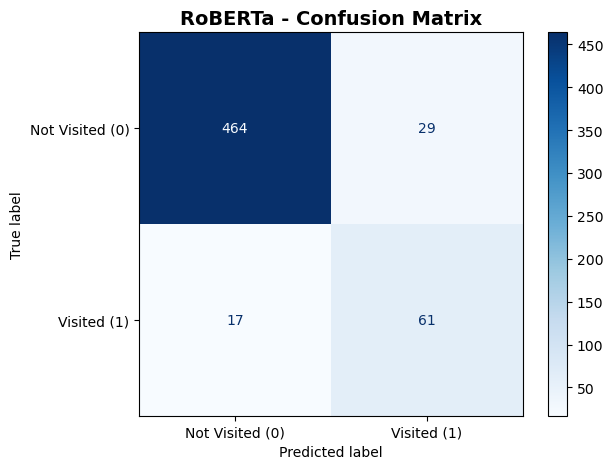

In [23]:
predictions_roberta = trainer_roberta.predict(test_dataset_roberta)
y_pred_roberta = np.argmax(predictions_roberta.predictions, axis=1)

# Evaluate and display metrics
roberta_results = evaluate_model(y_test, y_pred_roberta, model_name="RoBERTa")

#### 4.3 Model Comparison

We compare the performance of BERT and RoBERTa on the journey classification task across all key metrics.

In [25]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': 'BERT',
        'Accuracy': bert_results['accuracy'],
        'Precision': bert_results['precision'],
        'Recall': bert_results['recall'],
        'F1_Score': bert_results['f1_score']
    },
    {
        'Model': 'RoBERTa',
        'Accuracy': roberta_results['accuracy'],
        'Precision': roberta_results['precision'],
        'Recall': roberta_results['recall'],
        'F1_Score': roberta_results['f1_score']
    }
])

comparison_df

,Model,Accuracy,Precision,Recall,F1_Score
0,BERT,0.894921,0.586538,0.782051,0.67033
1,RoBERTa,0.919440,0.677778,0.782051,0.72619


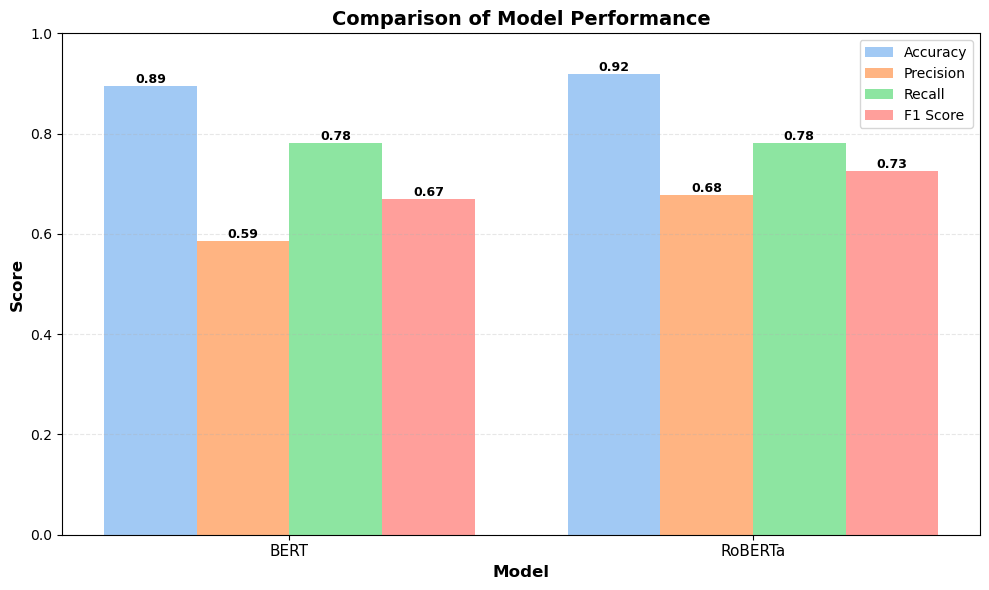

In [26]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
x = np.arange(len(comparison_df))
width = 0.2

colors = sns.color_palette('pastel', n_colors=4)

# Create bars for each metric
for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = ax.bar(x + i * width, values, width, label=metric.replace('_', ' '), color=colors[i])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize plot
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Model Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'], fontsize=11)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 5. Journey Extraction and Mapping

#### 5.1 Extract Correctly Predicted Journey Cities

In [39]:
# Extract predicted journey visits (model predicts 1)
predicted_journey_indices = []

for i in range(len(y_pred_roberta)):
    if y_pred_roberta[i] == 1:
        predicted_journey_indices.append(i)

print("Total predicted journey visits:", len(predicted_journey_indices))

Total predicted journey visits: 90


In [40]:
# Build the predicted journey dataframe
predicted_journey_df = []

for idx in predicted_journey_indices:
    predicted_journey_df.append({
        'chapter': df_test.iloc[idx]['chapter'],
        'sent_num': df_test.iloc[idx]['sent_num'],
        'sentence': df_test.iloc[idx]['sentence'],
        'city': df_test.iloc[idx]['cities']
    })

predicted_journey_df = pd.DataFrame(predicted_journey_df)
predicted_journey_df.head(10)

,chapter,sent_num,sentence,city
0,7,12,“I am.” “And this man is your servant?” “He is...,London
1,7,22,"He took up his note-book, which contained the ...",London
2,7,22,"He took up his note-book, which contained the ...",Paris
3,7,22,"He took up his note-book, which contained the ...",Turin
4,7,22,"He took up his note-book, which contained the ...",Brindisi
5,7,22,"He took up his note-book, which contained the ...",Suez
6,7,24,"On this Friday, October 9th, he noted his arri...",Suez
7,8,4,So this is Suez?” “Yes.” “In Egypt?” “Certainl...,Suez
8,8,18,"After a few minutes silence, Fix resumed: “You...",London
9,8,26,"And he doesn’t spare the money on the way, eit...",London


#### 5.2 Order Cities Chronologically

We sort the journey stops by their appearance in the book (chapter and sentence number) to reconstruct the actual travel route.

In [42]:
# Sort by chapter and sentence number
journey_df_sorted = predicted_journey_df.sort_values(['chapter', 'sent_num']).reset_index(drop=True)

print(f"Total predicted journey visits: {len(journey_df_sorted)}")
journey_df_sorted.head(10)

Total predicted journey visits: 90


,chapter,sent_num,sentence,city
0,7,12,“I am.” “And this man is your servant?” “He is...,London
1,7,22,"He took up his note-book, which contained the ...",London
2,7,22,"He took up his note-book, which contained the ...",Paris
3,7,22,"He took up his note-book, which contained the ...",Turin
4,7,22,"He took up his note-book, which contained the ...",Brindisi
5,7,22,"He took up his note-book, which contained the ...",Suez
6,7,24,"On this Friday, October 9th, he noted his arri...",Suez
7,8,4,So this is Suez?” “Yes.” “In Egypt?” “Certainl...,Suez
8,8,18,"After a few minutes silence, Fix resumed: “You...",London
9,8,26,"And he doesn’t spare the money on the way, eit...",London


In [ ]:
def build_journey_route(journey_df_sorted, unique_stops=True):
    """
    Build the journey route from sorted predictions.
    Parameters:
    - journey_df_sorted : DataFrame Predicted journey sentences sorted by chapter and sent_num.
    - unique_stops : bool, default True
        If True, keep only the first visit to each city (unique stops).
        If False, keep all visits in order.
    """
    if unique_stops:
        # Keep only first visit to each city
        route_rows = []
        seen_cities = set()

        for _, row in journey_df_sorted.iterrows():
            city = row['city']
            if city not in seen_cities:
                route_rows.append({
                    'city': city,
                    'chapter': row['chapter'],
                    'sent_num': row['sent_num'],
                    'first_mention': row['sentence'][:80] + '...',
                })
                seen_cities.add(city)

        # Add explicit return to starting city
        if len(journey_df_sorted) > 0 and len(route_rows) > 0:
            last_city_row = journey_df_sorted.iloc[-1]
            first_city = route_rows[0]['city']

            
            if last_city_row['city'] == first_city and route_rows[-1]['city'] != first_city:
                route_rows.append({
                    'city': last_city_row['city'],
                    'chapter': last_city_row['chapter'],
                    'sent_num': last_city_row['sent_num'],
                    'first_mention': last_city_row['sentence'][:80] + '... (Return)',
                })

        route_df = pd.DataFrame(route_rows)

    else:
        # Collapse consecutive duplicates (no movement)
        route_df = journey_df_sorted.loc[journey_df_sorted['city'].shift() != journey_df_sorted['city']].reset_index(drop=True)

    return route_df

In [55]:
final_journey_df = build_journey_route(journey_df_sorted, unique_stops=True)
final_journey_df.head(10)

,city,chapter,sent_num,first_mention
0,London,7,12,“I am.” “And this man is your servant?” “He is...
1,Paris,7,22,"He took up his note-book, which contained the ..."
2,Turin,7,22,"He took up his note-book, which contained the ..."
3,Brindisi,7,22,"He took up his note-book, which contained the ..."
4,Suez,7,22,"He took up his note-book, which contained the ..."
5,Aden,9,37,The following night they passed through the St...
6,Bombay,9,52,The steamer entered the road formed by the isl...
7,Allahabad,14,14,The station at Allahabad was reached about ten...
8,Calcutta,14,15,Phileas Fogg would thus be able to arrive in t...
9,Benares,14,53,At half-past twelve the train stopped at Benar...


#### 5.3 Final Journey Mapping

We now have the protagonist's complete journey route extracted from the text, ordered chronologically, and ready for visualization.

In [56]:
geolocator = Nominatim(user_agent="phileas_fogg_journey_mapper")

# Get coordinates for each city
journey_with_coords = []

for idx, row in final_journey_df.iterrows():
    city = row['city']
    
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            journey_with_coords.append({
                'order': idx + 1,
                'chapter': row['chapter'],
                'sent_num': row['sent_num'],
                'city': city,
                'latitude': location.latitude,
                'longitude': location.longitude
            })
            print(f"{city}: ({location.latitude:.4f}, {location.longitude:.4f})")
        else:
            print(f"{city}: Could not geocode")
        
        time.sleep(1)
        
    except Exception as e:
        print(f"{city}: Error - {e}")

journey_coords_df = pd.DataFrame(journey_with_coords)
journey_coords_df.head()

London: (51.5074, -0.1278)
Paris: (48.8535, 2.3484)
Turin: (45.0678, 7.6825)
Brindisi: (40.6359, 17.6885)
Suez: (29.9745, 32.5371)
Aden: (12.7896, 45.0285)
Bombay: (19.0550, 72.8692)
Allahabad: (25.4381, 81.8338)
Calcutta: (22.5726, 88.3639)
Benares: (25.3356, 83.0076)
Hong Kong: (22.3506, 114.1849)
Singapore: (1.3571, 103.8195)
Yokohama: (35.4503, 139.6344)
San Francisco: (37.7793, -122.4193)
Nagasaki: (33.1155, 129.7874)
Shanghai: (31.2313, 121.4700)
New York: (40.7127, -74.0060)
Oakland: (37.8045, -122.2714)
Sacramento: (38.5811, -121.4939)
Reno: (50.4678, 7.3520)
Independence: (39.0925, -94.4138)
Missouri: (38.7605, -92.5618)
Ogden: (41.2230, -111.9738)
Salt Lake City: (40.7596, -111.8868)
North Platte: (41.1368, -100.7613)
Kearney: (40.4906, -98.9472)
Omaha: (41.2587, -95.9384)
Davenport: (41.5236, -90.5771)
Rock Island: (41.4412, -90.5766)
Chicago: (41.8756, -87.6244)
Indiana: (40.3270, -86.1747)
Jersey City: (40.7216, -74.0475)
Long Island: (40.8515, -73.0994)
Bordeaux: (44.8412

,order,chapter,sent_num,city,latitude,longitude
0,1,7,12,London,51.507446,-0.127765
1,2,7,22,Paris,48.853495,2.348391
2,3,7,22,Turin,45.067755,7.682489
3,4,7,22,Brindisi,40.635860,17.688498
4,5,7,22,Suez,29.974498,32.537086


In [ ]:
def repair_longitudes(df, margin=20, limit=5, sleep_secs=1.0):
    """
    Fix cities whose longitude is inconsistent with their neighbours.
    Parameters:
        - df : DataFrame with 'city', 'latitude', 'longitude' columns.
        - margin : float, default 20
            Margin added to allowed longitude range.
        - limit : int, default 5
            Number of geocode candidates to consider.
        - sleep_secs : float, default 1.0
            Seconds to sleep between geocode calls.
    """
    df = df.copy()
    df["fixed"] = False

    for i in range(1, len(df) - 1):
        prev_lon = df.loc[i - 1, "longitude"]
        curr_lon = df.loc[i, "longitude"]
        next_lon = df.loc[i + 1, "longitude"]

        # Skip if neighbours cross the Pacific dateline
        if abs(prev_lon - next_lon) > 180:
            continue

        low  = min(prev_lon, next_lon) - margin
        high = max(prev_lon, next_lon) + margin

        # Already in a reasonable range
        if low <= curr_lon <= high:
            continue

        city = df.loc[i, "city"]
        print(f"Fixing {city}: lon={curr_lon:.3f}, allowed [{low:.2f}, {high:.2f}]")

        try:
            candidates = geolocator.geocode(
                city,
                exactly_one=False,
                limit=limit,
                timeout=10
            ) or []
        except Exception as e:
            print("  geocode error:", e)
            continue

        # Filter candidates to ones inside the allowed band
        mid_lon = (prev_lon + next_lon) / 2.0
        valid = [c for c in candidates if low <= c.longitude <= high]
        if not valid:
            print(" no candidate in range, keeping original")
            continue

        # Choose candidate closest to neighbours' midpoint
        best = min(valid, key=lambda c: abs(c.longitude - mid_lon))

        df.loc[i, "latitude"] = best.latitude
        df.loc[i, "longitude"] = best.longitude
        df.loc[i, "fixed"] = True

        print(f"  -> ({best.latitude:.4f}, {best.longitude:.4f})")
        time.sleep(sleep_secs)

    return df

journey_coords_df = repair_longitudes(journey_coords_df, margin=20, limit=5, sleep_secs=1.0)
journey_coords_df

Fixing San Francisco: lon=-122.419, allowed [109.79, 159.63]
  no candidate in range, keeping original
Fixing Reno: lon=7.352, allowed [-141.49, -74.41]
  -> (37.9303, -98.1056)
Fixing Queenstown: lon=168.661, allowed [-26.26, 19.42]
  -> (51.8501, -8.2943)


,order,chapter,sent_num,city,latitude,longitude,fixed
0,1,7,12,London,51.507446,-0.127765,False
1,2,7,22,Paris,48.853495,2.348391,False
2,3,7,22,Turin,45.067755,7.682489,False
3,4,7,22,Brindisi,40.635860,17.688498,False
4,5,7,22,Suez,29.974498,32.537086,False
5,6,9,37,Aden,12.789585,45.028504,False
6,7,9,52,Bombay,19.054999,72.869203,False
7,8,14,14,Allahabad,25.438130,81.833800,False
8,9,14,15,Calcutta,22.572646,88.363895,False
9,10,14,53,Benares,25.335649,83.007629,False


In [ ]:
# Create base map
center_lat = journey_coords_df['latitude'].mean()
center_lon = journey_coords_df['longitude'].mean()

journey_map = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=2,
    tiles='OpenStreetMap'
)

# Draw route lines with special handling for Pacific crossing
for i in range(len(journey_coords_df) - 1):
    start = journey_coords_df.iloc[i]
    end = journey_coords_df.iloc[i + 1]
    
    start_coords = [start['latitude'], start['longitude']]
    end_coords = [end['latitude'], end['longitude']]
    
    # If longitude difference > 180, it's crossing the dateline
    lon_diff = end['longitude'] - start['longitude']
    
    if abs(lon_diff) > 180:
        # Pacific crossing - add intermediate point
        mid_lat = (start['latitude'] + end['latitude']) / 2
        
        # Add point in the middle of Pacific Ocean
        if start['longitude'] > 0:
            mid_lon = 180  # International Date Line
        else:
            mid_lon = -180
            
        # Draw as two segments
        folium.PolyLine(
            [start_coords, [mid_lat, mid_lon]],
            color='red',
            weight=3,
            opacity=0.8
        ).add_to(journey_map)
        
        folium.PolyLine(
            [[mid_lat, -mid_lon], end_coords],
            color='red',
            weight=3,
            opacity=0.8
        ).add_to(journey_map)
    else:
        # Normal connection
        folium.PolyLine(
            [start_coords, end_coords],
            color='red',
            weight=3,
            opacity=0.8
        ).add_to(journey_map)

# Add markers for each city
first_city = journey_coords_df.iloc[0]['city']
last_city  = journey_coords_df.iloc[-1]['city']
same_start_end = (first_city == last_city)

# One row per city, with all visit orders collected into a list
marker_info = (
    journey_coords_df
    .groupby('city')
    .agg({
        'latitude': 'first',
        'longitude': 'first',
        'order': lambda s: sorted(s.tolist()) 
    })
    .reset_index()
)

for _, row in marker_info.iterrows():
    city = row['city']
    visits = row['order']
    visits_str = ", ".join(f"#{o}" for o in visits)

    if same_start_end and city == first_city:
        icon_color = "purple"
        icon = "flag"
        prefix = "START & END: "
    elif city == first_city:
        icon_color = "green"
        icon = "play"
        prefix = "START: "
    elif city == last_city:
        icon_color = "red"
        icon = "stop"
        prefix = "END: "
    else:
        icon_color = "blue"
        icon = "info-sign"
        prefix = ""

    popup_text = f"{prefix}{city} (Stops {visits_str})"

    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=city,
        popup=popup_text,
        icon=folium.Icon(color=icon_color, icon=icon, prefix="glyphicon"),
    ).add_to(journey_map)

# Display the map
journey_map

In [ ]:
journey_map.save('around_the_world_journey_map.html')

![Map Description](mapping_result.png)